In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import sys
import regex as re
import io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import math
import tensorflow as tf
import h5py
import copy
from torch.utils.data import DataLoader, Dataset
from numpy.linalg import norm
from scipy.spatial.distance import cosine
from scipy.special import softmax
from copy import deepcopy
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import seaborn
from torch.autograd import Variable

LOCAL = True
BASE_DIR = '../'

if not LOCAL:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_DIR = '/content/drive/My Drive/Colab Notebooks/thesis/'

sys.path.append(BASE_DIR + 'lib')
sys.path.append(BASE_DIR + 'config')
from preprocessing import process_sakt, save_h5
import dataset_parameters as params

# DATASET = 'akribian'
# DATASET = 'assistments_2009'
# DATASET = 'assistments_2012'
# DATASET = 'junyi_academy'
DATASET = 'ednet'

TIME_STEPS = params.time_steps_dict[DATASET]

IN_DATA_PATH = BASE_DIR + 'data/' + DATASET + '/processed/sakt/' 
MODEL_PATH = BASE_DIR + 'models/keetar/' 

# Training parameters
BATCH_SIZE = 64
LATENT_DIM = 128 # latent dimension
PADDING = 0
SHUFFLE = True
TIME_STEPS = params.time_steps_dict[DATASET]
#EPOCHS = params.epochs_dict[DATASET]
EPOCHS = 100
NUMBER_OF_EXERCISES = params.exercise_dict[DATASET]
NUMBER_OF_IDS = params.exercise_id_dict[DATASET]
ROWS_PER_READ = 1000000
HEADS_EN = 4
LAYERS_EN = 1
WARMUP = 4000
DROPOUT = 0.1

EARLY_STOPPING_TOLERANCE = 3

# File paths
INPUT_PATH = IN_DATA_PATH + "processed.h5"

In [2]:
print("CUDA available: %i" % torch.cuda.is_available())
cuda = torch.device("cuda:0")
torch.set_default_tensor_type('torch.cuda.FloatTensor')

CUDA available: 1


# Model class

In [3]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

    def zero_grad(self):
        self.optimizer.zero_grad()
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [4]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe = pe.unsqueeze(0)
        #print(pe.shape)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"

    # Data is in the format (b,h,n,d_k)
    d_k = key.size(-1)
    n = key.size(-2)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
                / math.sqrt(d_k)
    # scores is in the shape (b, h, n, n)
    # mask is in the shape (b, h, n, n)
    if mask is not None:
        scores = scores.masked_fill(mask == False, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiheadAttention(nn.Module):
    def __init__(self, number_of_heads, dim_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiheadAttention, self).__init__()
        assert dim_model % number_of_heads == 0
        # We assume d_v always equals d_k
        self.d_k = dim_model // number_of_heads
        self.h = number_of_heads
        self.linears = nn.ModuleList([nn.Linear(dim_model, dim_model) for _ in range(4)])
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None, padding_mask=None):

        "Implements Figure 2"
        # if mask is not None:
        #     # Same mask applied to all h heads.
        #     mask = mask.unsqueeze(1)
        nbatches = key.size(0)
        seq_len = key.size(1)
        
        # right now the data is in the shape (b,n,d_model)
        # 1) Do all the linear projections in batch from d_model => h x d_k and then transposed to swap dim of h and n
        # q,k,v will each have shape (b, h, n, d_k)
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        # mask has shape (n, n)
        # mask = mask.unsqueeze(0).unsqueeze(0).repeat(nbatches, self.h, 1, 1) # (n,n) -> (b,h,n,n)
        # padding mask has shape (b, n)
        padding_mask = padding_mask.unsqueeze(1).unsqueeze(1).repeat(1, self.h, 1, 1) # (b,n) -> (b,h,n,n)
        # data has shape (b, h, n, d_k)
        x, self.attn = attention(query, key, value, 
                                 #mask=mask * padding_mask,                                 
                                 mask=padding_mask,
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

class Feed_Forward_block(nn.Module):
    """
    out =  Relu( M_out*w1 + b1) *w2 + b2
    """
    def __init__(self, dim_ff):
        super().__init__()
        self.layer1 = nn.Linear(in_features=dim_ff , out_features=dim_ff)
        self.layer2 = nn.Linear(in_features=dim_ff , out_features=dim_ff)

    def forward(self,ffn_in):
        return  self.layer2(   F.relu( self.layer1(ffn_in) )   )
        

class Encoder_block(nn.Module):
    """
    M = SkipConct(Multihead(LayerNorm(Qin;Kin;Vin)))
    O = SkipConct(FFN(LayerNorm(M)))
    """

    def __init__(self , dim_model, heads_en, total_ex ,total_cat, seq_len, dropout):
        super().__init__()
        self.seq_len = seq_len
        
        self.multi_en = MultiheadAttention( number_of_heads = heads_en, dim_model = dim_model, dropout = dropout  )     # multihead attention ## todo add dropout, LayerNORM
        self.ffn_en = Feed_Forward_block( dim_model )                                            # feedforward block   ## todo dropout, LayerNorm
        self.layer_norm1 = nn.LayerNorm( dim_model )
        self.layer_norm2 = nn.LayerNorm( dim_model )
        self.dropout = nn.Dropout(p=dropout)


    def forward(self, in_ex, padding_mask = None):

        # input is batch-first (b,n,d)
        out = in_ex                                      # Applying positional embedding

        # out = out.permute(1,0,2)                         # -> (n,b,d)

        # last query trick
        # right now this invalidates the mask, allowing for future peeking. needs to be fixed

        # index for last query
        last_indices = torch.count_nonzero(padding_mask, 1) - 1 
        last_indices = last_indices.unsqueeze(1).unsqueeze(1).repeat(1, 1, out.size(2))
        query = out.gather(1, last_indices.cuda())

        #Multihead attention                            
        b,n,d = out.shape
        out = self.layer_norm1( out )                           # Layer norm
        skip_out = out
        # attention function accepts batch-first format
        out = self.multi_en( query , out , out ,
                                mask=subsequent_mask(n)
                                ,padding_mask = padding_mask 
                                )  # attention mask upper triangular
        out = out + skip_out                                    # skip connection
        out = self.dropout(out)

        #feed forward
        # out = out.permute(1,0,2)                                # -> (b,n,d)
        out = self.layer_norm2( out )                           # Layer norm 
        skip_out = out
        out = self.ffn_en( out )
        out = out + skip_out                                    # skip connection
        out = self.dropout(out)

        return out

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


def get_mask(seq_len):
    ##todo add this to device
    return torch.from_numpy( np.triu(np.ones((seq_len ,seq_len)), k=1).astype('bool')).cuda()

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (size, size)
    subsequent_mask = np.tril(np.ones(attn_shape), k=0).astype('uint8')
    return torch.from_numpy(subsequent_mask).cuda() == 1

def get_pos(seq_len):
    # use sine positional embeddinds
    return torch.arange( seq_len ).unsqueeze(0)
    #return torch.arange( seq_len ).unsqueeze(1)

class keetar(nn.Module):
    def __init__(self, dim_model, num_en, heads_en, total_ex ,total_cat, total_in, seq_len, dropout ):
        super().__init__( )

        self.num_en = num_en
        self.seq_len = seq_len

        self.embd_ex =   nn.Embedding( total_ex, embedding_dim = dim_model ) # embedings  q,k,v = E = exercise ID embedding, category embedding, and positionembedding.
        self.embd_cat =  nn.Embedding( total_cat, embedding_dim = dim_model )
        self.embd_correct = nn.Embedding( total_in, embedding_dim = dim_model )
        self.embd_pos   = nn.Embedding(  seq_len , embedding_dim = dim_model ) # positional embedding

        self.in_ffn = nn.Linear(dim_model + 2, dim_model)
        self.encoder = get_clones(Encoder_block(dim_model, heads_en, total_ex, total_cat, seq_len, dropout), num_en)
        self.lstm = nn.LSTM(dim_model, dim_model, 1, dropout = dropout)
        self.out_ffn = nn.Linear(dim_model, 1)

        self.relu = nn.ReLU()

        self.layer_norm = nn.LayerNorm( dim_model )

        self.dout = nn.Dropout(dropout)
    
    def forward(self, in_ex, in_cat, in_in, in_elapsed, in_ts ):

        padding_mask = in_ex > 0  # (b,n). pytorch wants it in this format
        padding_mask = padding_mask.cuda()

        #combining the embedings
        in_ex = self.embd_ex( in_ex )
        in_cat = self.embd_cat( in_cat )
        in_in = self.embd_correct( in_in )

        in_pos = get_pos(self.seq_len)
        in_pos = self.embd_pos( in_pos )

        in_ex = in_ex + in_cat + in_in # (b,n,d)
        in_ex = in_ex + in_pos

        in_ex = torch.cat((in_ex, in_elapsed, in_ts), 2)

        in_ex = self.in_ffn(in_ex)

        in_ex = self.relu(in_ex)
        
        ## Pass through each of the encoder blocks in sequence
        # input (b,n,d); output (b,n,d)
        for x in range(self.num_en):
            in_ex = self.encoder[x]( in_ex, padding_mask = padding_mask)

        in_ex = self.dout(in_ex)

        ## Res connection
        in_ex = in_ex.permute(1,0,2) # -> (n,b,d)
        res = in_ex
        ## Pass through LSTM
        # input (n,b,d); output (n,b,d)
        in_ex, _ = self.lstm(in_ex)
        in_ex = in_ex + res

        ## Return to batch-first format
        in_ex = in_ex.permute(1,0,2) # -> (b,n,d)
        # Layer norm
        in_ex = self.layer_norm(in_ex)
        ## Pass through final FFN
        in_ex = self.out_ffn(in_ex)
        
        ## Sigmoid and output
        in_ex = torch.sigmoid(in_ex)
        return in_ex

# Model training

In [5]:
model = keetar(dim_model=LATENT_DIM,
            seq_len=TIME_STEPS,
            num_en=LAYERS_EN,
            heads_en=HEADS_EN,
            total_ex= NUMBER_OF_IDS,
            total_cat= NUMBER_OF_EXERCISES,
            total_in= 3,
            dropout = DROPOUT ).cuda()

criterion = nn.BCELoss()
#optimizer = NoamOpt(LATENT_DIM, 1, WARMUP, optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8))
#optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=WEIGHT_DECAY)
optimizer = optim.Adam(model.parameters(), lr=0.001)

C:\Users\Sepehr\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [6]:
## Training the model
print_freq = 10
graph_freq = 10

losses_history = []

val_aucs = []

previous_auc = 0.0

no_improvement_streak = 0
best_auc = 0.0

h5_file = h5py.File(INPUT_PATH,'r')

# labels_val = torch.from_numpy(h5_file['labels_val'][:]).flatten()

number_of_train_windows = h5_file['exercises_train'].shape[0]
number_of_val_windows = h5_file['exercises_val'].shape[0]

for epoch in range(EPOCHS):
  print("Epoch %i" % (epoch+1))
  total_loss_print = 0.0
  total_loss_graph = 0.0

  for read_index in range(0, number_of_train_windows, ROWS_PER_READ):

    exercises_train = h5_file['exercises_train'][read_index:read_index+ROWS_PER_READ]
    exercise_ids_train = h5_file['exercise_ids_train'][read_index:read_index+ROWS_PER_READ]
    labels_train = h5_file['labels_train'][read_index:read_index+ROWS_PER_READ]
    elapsed_train = h5_file['elapsed_train'][read_index:read_index+ROWS_PER_READ]
    timestamp_train = h5_file['timestamps_train'][read_index:read_index+ROWS_PER_READ]

    random_indices = np.arange(len(exercises_train))
    np.random.shuffle(random_indices)

    exercises_train = exercises_train[random_indices]
    exercise_ids_train = exercise_ids_train[random_indices]
    labels_train = labels_train[random_indices]

    # found_exercises = len(list(set(exercises_train.flatten())))
    # print("found %i out of max %i exercises" % (found_exercises, NUMBER_OF_EXERCISES))
    # print("there are %i correctness levels" % len(list(set(labels_train.flatten()))))
    # print(list(set(exercises_train.flatten())))

    for idx in range(0, len(exercises_train), BATCH_SIZE):
      # Retrieve data
      cat_samples = torch.from_numpy(exercises_train[idx:idx + BATCH_SIZE]).long().cuda()
      id_samples = torch.from_numpy(exercise_ids_train[idx:idx + BATCH_SIZE]).long().cuda()
      label = torch.from_numpy(labels_train[idx:idx + BATCH_SIZE]).long().cuda()
      elapsed = torch.from_numpy(elapsed_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
      timestamp = torch.from_numpy(timestamp_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()

      shifted_label = torch.roll(label, 1)
      shifted_label[:,0] = 2
      label = torch.unsqueeze(label, 2)

      # Reset optimizer
      optimizer.zero_grad()

      # Predict
      out = model(id_samples, cat_samples, shifted_label, elapsed, timestamp)

      if torch.isnan(out).any():
        print("Model output contains nan")
        bad_index = torch.isnan(out.squeeze())
        print("Offending input:")
        print("ID: ")
        print(id_samples[bad_index])
        print("Category: ")
        print(cat_samples[bad_index])
        raise Exception("Model output contains nan")

      # print("output:")
      # print(out.shape)
      # print(out)

      # Calculate loss 
      loss = criterion(out, label.float())
      total_loss_print += loss.item()
      total_loss_graph += loss.item()

      # Optimize
      loss.backward()
      optimizer.step()

      idx_discrete = int(idx / BATCH_SIZE)

      # Print status
      if (idx_discrete % print_freq == print_freq - 1):
        avg_loss = total_loss_print/print_freq
        sys.stdout.write("\rIteration %i/%i, avg loss %f" % (idx+1, number_of_train_windows, avg_loss))
        sys.stdout.flush()
        total_loss_print = 0.0

      # Append to graph
      if (idx_discrete % graph_freq == graph_freq - 1):
        avg_loss = total_loss_graph/graph_freq
        losses_history.append(avg_loss)
        total_loss_graph = 0.0
          
  # Validation step
  # Set evaluation mode
  outs_preds = np.array([])
  val_labels_last = np.array([])
  model.eval()
  # Turn off grad calculation
  with torch.no_grad():
    # Iterate through val data
    for read_index in range(0, number_of_val_windows, ROWS_PER_READ):
      exercises_val = h5_file['exercises_val'][read_index:read_index+ROWS_PER_READ]    
      exercise_ids_val = h5_file['exercise_ids_val'][read_index:read_index+ROWS_PER_READ]
      labels_val = h5_file['labels_val'][read_index:read_index+ROWS_PER_READ]
      elapsed_val = h5_file['elapsed_val'][read_index:read_index+ROWS_PER_READ]
      timestamp_val = h5_file['timestamps_val'][read_index:read_index+ROWS_PER_READ]
      for idx in range(0, len(exercises_val), BATCH_SIZE):
        cat_samples_val = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]).long().cuda()
        id_samples_val = torch.from_numpy(exercise_ids_val[idx:idx + BATCH_SIZE]).long().cuda()
        elapsed = torch.from_numpy(elapsed_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
        timestamp = torch.from_numpy(timestamp_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
        label = labels_val[idx:idx + BATCH_SIZE]
        shifted_label_val = torch.roll(torch.from_numpy(label), 1).long().cuda()
        shifted_label_val[:,0] = 2

        outs_pred = model(id_samples_val, cat_samples_val, shifted_label_val, elapsed, timestamp)        

        ## method 1: slice entire sequence
        # padding_mask = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]) != 0      
        # outs_pred_np = outs_pred.cpu().detach().numpy().squeeze(2)
        # outs_pred_indexed = outs_pred_np[padding_mask]
        # label_indexed = label[padding_mask]

        ## method 2: slice only the last non-padding element
        last_indices = torch.count_nonzero(torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]), 1) - 1
        outs_pred_indexed = outs_pred.squeeze().gather(1, last_indices.view(-1,1).cuda()).cpu().detach().numpy()
        label_indexed = torch.from_numpy(label).gather(1, last_indices.view(-1,1)).cpu().detach().numpy()

        val_labels_last = np.append(val_labels_last, label_indexed)
        outs_preds = np.append(outs_preds, outs_pred_indexed)

  # Revert to training mode
  model.train()

  # labels_val = h5_file['labels_val'][:].flatten()
  fpr, tpr, thresholds = roc_curve(val_labels_last, outs_preds)
  auc_score = auc(fpr, tpr)
  # auc_score = roc_auc_score(val_labels_last, outs_preds)
  val_aucs.append(auc_score)
  print("\nValidation AUC: %f" % auc_score)
  auc_diff = auc_score - previous_auc
  if epoch != 0:
    print("AUC difference: %f" % auc_diff)

  if auc_score < best_auc:
    no_improvement_streak += 1
  else:
    no_improvement_streak = 0
    best_auc = auc_score
    torch.save(model.state_dict(), MODEL_PATH + DATASET + ".torch")
    print("Model saved")

  if no_improvement_streak >= EARLY_STOPPING_TOLERANCE:
    break

  previous_auc = auc_score

h5_file.close()

Epoch 1
Iteration 457537/457705, avg loss 0.199806
Validation AUC: 0.764373
Model saved
Epoch 2
Iteration 457537/457705, avg loss 0.214380
Validation AUC: 0.765490
AUC difference: 0.001117
Model saved
Epoch 3
Iteration 457537/457705, avg loss 0.222972
Validation AUC: 0.765437
AUC difference: -0.000053
Epoch 4
Iteration 457537/457705, avg loss 0.212547
Validation AUC: 0.766767
AUC difference: 0.001330
Model saved
Epoch 5
Iteration 457537/457705, avg loss 0.219376
Validation AUC: 0.758644
AUC difference: -0.008123
Epoch 6
Iteration 457537/457705, avg loss 0.200125
Validation AUC: 0.759808
AUC difference: 0.001164
Epoch 7
Iteration 457537/457705, avg loss 0.209723
Validation AUC: 0.749069
AUC difference: -0.010739


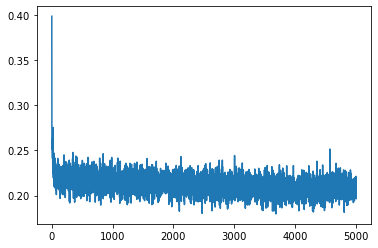

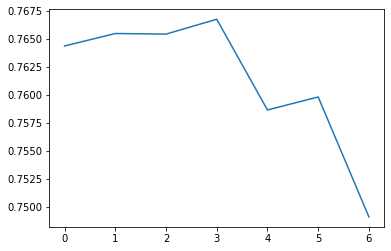

In [7]:
plt.figure(1)
plt.plot(losses_history)

plt.figure(2)
plt.plot(val_aucs)

In [8]:
# Load the best 
model.load_state_dict(torch.load(MODEL_PATH + DATASET + ".torch"))

<All keys matched successfully>

In [9]:
model.eval()

outs_preds = np.array([])
test_labels_last = np.array([])

BATCH_SIZE = 16

# predict iteratively in batches to avoid overloading VRAM
with h5py.File(INPUT_PATH,'r') as h5_file:
  number_of_test_windows = h5_file['exercises_test'].shape[0]
  for read_index in range(0, number_of_test_windows, ROWS_PER_READ):
    exercises_test = h5_file['exercises_test'][read_index:read_index+ROWS_PER_READ]    
    exercise_ids_test = h5_file['exercise_ids_test'][read_index:read_index+ROWS_PER_READ]
    labels_test = h5_file['labels_test'][read_index:read_index+ROWS_PER_READ]
    elapsed_test = h5_file['elapsed_test'][read_index:read_index+ROWS_PER_READ]
    timestamp_test = h5_file['timestamps_test'][read_index:read_index+ROWS_PER_READ]
    for idx in range(0, len(exercises_test), BATCH_SIZE):
      cat_samples_test = torch.from_numpy(exercises_test[idx:idx + BATCH_SIZE]).long().cuda()
      id_samples_test = torch.from_numpy(exercise_ids_test[idx:idx + BATCH_SIZE]).long().cuda()
      elapsed = torch.from_numpy(elapsed_test[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
      timestamp = torch.from_numpy(timestamp_test[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
      label = labels_test[idx:idx + BATCH_SIZE]
      shifted_label_test = torch.roll(torch.from_numpy(label), 1).long().cuda()
      shifted_label_test[:,0] = 2

      outs_pred = model(id_samples_test, cat_samples_test, shifted_label_test, elapsed, timestamp)

      ## method 1: slice entire sequence
      # padding_mask = torch.from_numpy(exercises_test[idx:idx + BATCH_SIZE]) != 0      
      # outs_pred_np = outs_pred.cpu().detach().numpy().squeeze(2)
      # outs_pred_indexed = outs_pred_np[padding_mask]
      # label_indexed = label[padding_mask]

      # method 2: slice only the last non-padding element
      last_indices = torch.count_nonzero(torch.from_numpy(exercises_test[idx:idx + BATCH_SIZE]), 1) - 1
      outs_pred_indexed = outs_pred.squeeze().gather(1, last_indices.view(-1,1).cuda()).cpu().detach().numpy()
      label_indexed = torch.from_numpy(label).gather(1, last_indices.view(-1,1)).cpu().detach().numpy()

      outs_preds = np.append(outs_preds, outs_pred_indexed)
      test_labels_last = np.append(test_labels_last, label_indexed)


print(outs_preds.shape)
print(test_labels_last.shape)

(30480,)
(30480,)


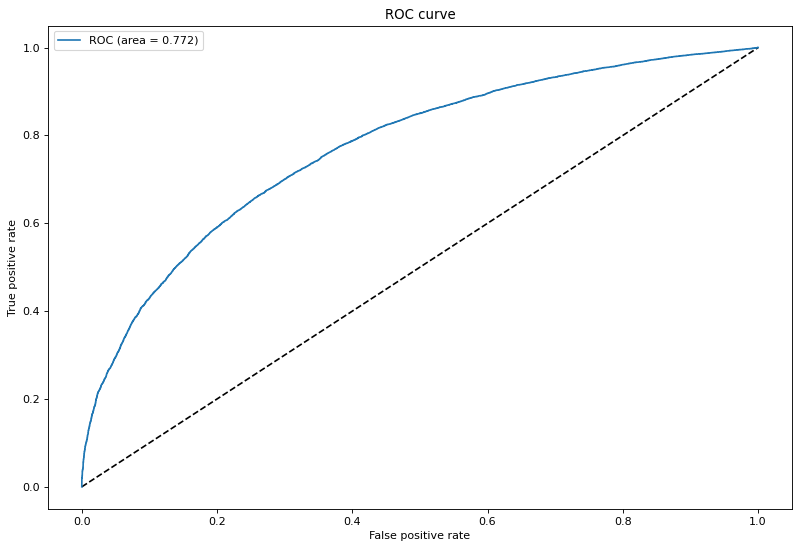

In [10]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels_last, outs_preds)
auc_score = auc(fpr_keras, tpr_keras)
# This one reports too high auc...
#auc_score = roc_auc_score(test_labels_last, outs_preds)

plt.figure(3, figsize=(12,8), dpi=80)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ROC (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

<AxesSubplot:>

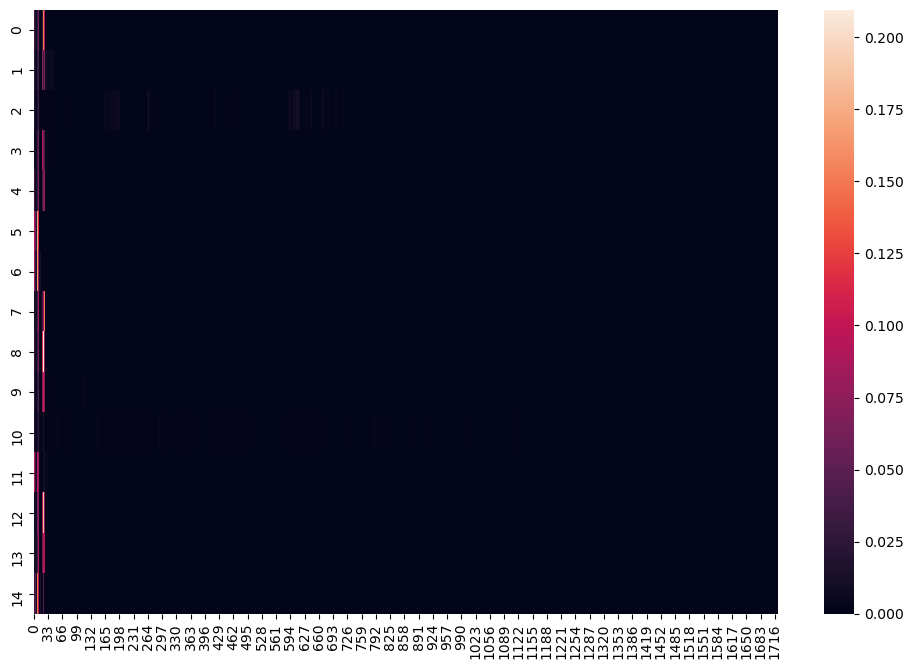

In [11]:
head_idx = 0
batch_idx = 1
attn = model.encoder[0].multi_en.attn[batch_idx:batch_idx + BATCH_SIZE].squeeze()
# attn = model.encoder[0].multi_en.attn[batch_idx, :].squeeze()
plt.figure(2, figsize=(12,8), dpi=100)
seaborn.heatmap(attn[:,0].cpu().detach().numpy())

torch.Size([1, 1723])
torch.Size([1, 1723])
torch.Size([1, 1723])
torch.Size([1, 1723, 1])
torch.Size([1, 1723, 1])
index index: 50


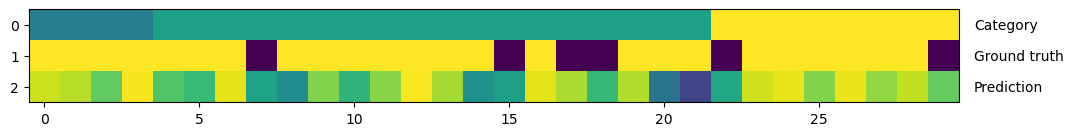

In [12]:
idx = 50
with h5py.File(INPUT_PATH,'r') as h5_file:
  exercises_test = torch.from_numpy(h5_file['exercises_test'][idx:idx+1]).long().cuda()
  exercise_ids_test = torch.from_numpy(h5_file['exercise_ids_test'][idx:idx+1]).long().cuda()
  labels_test = h5_file['labels_test'][idx:idx+1]
  shifted_label_test = torch.roll(torch.from_numpy(labels_test), 1).long().cuda()
  shifted_label_test[:,0] = 2  
  elapsed_test = h5_file['elapsed_test'][idx:idx+1]
  timestamp_test = h5_file['timestamps_test'][idx:idx+1]  
  elapsed = torch.from_numpy(elapsed_test).float().cuda().unsqueeze(2)
  timestamp = torch.from_numpy(timestamp_test).float().cuda().unsqueeze(2)

  print(exercise_ids_test.shape)
  print(exercises_test.shape)
  print(shifted_label_test.shape)
  print(elapsed.shape)  
  print(timestamp.shape)

  outs_pred = model(exercise_ids_test, exercises_test, shifted_label_test, elapsed, timestamp)        

  img_width = TIME_STEPS
  max_width = 30

  ground_truth = labels_test.squeeze()
  pred = outs_pred.squeeze().cpu().detach().numpy()

  # Define image
  img = np.ndarray((3, img_width))
  img = img[:, :max_width]

  # Set category color
  ex_color = exercises_test.squeeze().cpu().detach().numpy()
  color_dict = dict(enumerate(list(set(ex_color))))
  color_dict = {v:k for k,v in color_dict.items()}
  colors = list(map(lambda x: (color_dict[x] + 1)/len(color_dict.keys()), ex_color))
  colors = colors[-max_width:]
  img[0,:] = colors

  # Set ground truth color
  ground_truth = ground_truth[-max_width:]
  img[1,:] = ground_truth

  # Set prediction color
  pred = pred[-max_width:]
  img[2,:] = pred

  # Show the figure
  plt.figure(4, figsize=(12,8), dpi=100)
  plt.imshow(img)
  plt.text(max_width, 0.15, "Category")
  plt.text(max_width, 1.15, "Ground truth")
  plt.text(max_width, 2.15, "Prediction")

  # Index
  print("index index: %i" % idx)

In [13]:
with h5py.File(INPUT_PATH,'r') as hf:
  print(hf['labels_val'].shape)

(122015, 1723)
